# Установим все что надо



In [1]:
!nvidia-smi

Fri Mar 25 21:23:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%writefile install.sh
pip install einops
git clone https://github.com/CompVis/taming-transformers
pip install ftfy regex tqdm 
pip install omegaconf==2.0.0
pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2 torchvision==0.8.2
pip install torch_optimizer
pip install pytorch-lightning==1.0.8
pip install transformers==3.5.1
pip install bitsandbytes-cuda111
pip install pymorphy2
pip install ruclip==0.0.1
pip install gdown==4.4.0
!gdown https://drive.google.com/uc?id=1yB5nPXiJqYnoBEOannq_M5JJ2lpzhp3T 
!gdown https://drive.google.com/uc?id=1mXu9ThC3ET_uFGPwCYKCbOXqwma7wHo-
#pip install Flask
#pip install tg-logger
#pip install pyTelegramBotAPI
#curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
#curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt
#wget https://www.dropbox.com/s/2oxu7hw0y9fwdqs/M-BERT-Base-69-ViT%20Linear%20Weights.pkl
#!git clone https://github.com/sberbank-ai/ru-clip.git

Writing install.sh


In [ ]:
!sh install.sh

#VQ GAN +CLIP [based on ](https://www.reddit.com/r/azurisme/comments/nr4swt/vqganclip_zquantize_methodipynb/)

In [1]:
import argparse
import math
from pathlib import Path
import sys

import ruclip

sys.path.append('./taming-transformers')

from IPython import display
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
import bitsandbytes as bnb
from torch import nn, optim as optimi
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import torch_optimizer as optim
#from CLIP import clip

In [2]:
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
 
    vals = prompt.rsplit(':', 2)
 
    vals = vals + ['', '1', '-inf'][len(vals):]
    
    return vals[0], float(vals[1]), float(vals[2])
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        return clamp_with_grad(torch.cat(cutouts, dim=0), 0, 1)
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

In [3]:
#markdown imports

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os, random
import torch

import warnings
warnings.filterwarnings("ignore")

#import clip

#!git clone https://github.com/FreddeFrallan/Multilingual-CLIP
#%cd Multilingual-CLIP
#!bash get-weights.sh

In [4]:
#@markdown generate function
def text2image_QHM(text:str,iter:int,path:str,rand, x:int, y:int):
  """
  text - text promt
  iter - int count of iterations how much iters

  path - where to save

  rand - radom float for init gan
  
  """


  

  args = argparse.Namespace(
        prompts=[text],
        image_prompts=[],
        noise_prompt_seeds=[],
        noise_prompt_weights=[],
        size=[x, y],
        init_image=None,
        init_weight=rand,
        clip_model='ViT-B/32',
        vqgan_config='vqgan.16384.config.yml',
        vqgan_checkpoint='vqgan.16384.model.ckpt',
        step_size=0.1,
        cutn=4,
        cut_pow=1.,
        display_freq=50,
        seed=0,
    )
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  text_model, perceptor = ruclip.load('ruclip-vit-base-patch32-224', device=device)

  model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)

    
  cut_size = perceptor.image_size
  e_dim = model.quantize.e_dim
    
  
  f = 2**(model.decoder.num_resolutions - 1)# 2**(65000-1)

  make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
  n_toks = model.quantize.n_e

  toksX, toksY = args.size[0] // f, args.size[1] // f
  sideX, sideY = toksX * f, toksY * f
  z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
  z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

  if args.seed is not None:
      torch.manual_seed(args.seed)

  if args.init_image:
        pil_image = Image.open(args.init_image).convert('RGB')
        pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
        z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)

  else:
      one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
      z = one_hot @ model.quantize.embedding.weight
      z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
  
  z_orig = z.clone()
  z.requires_grad_(True)


    #opt = optim.Adadelta
  opt = bnb.optim.Adam8bit([z], lr=args.step_size)
  #optim.QHAdam([z], lr=args.step_size)

  normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                    std=[0.26862954, 0.26130258, 0.27577711])

  pMs = []

  for prompt in args.prompts:

      txt, weight, stop = parse_prompt(prompt)
     
      txt = perceptor.encode_text(txt).to(device)
      
     
      embed = text_model.encode_text(txt.unsqueeze(1)).to(device)
      


      pMs.append(Prompt(embed, weight, stop).to(device))

  for prompt in args.image_prompts:

      path, weight, stop = parse_prompt(prompt)
      img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
      batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))

      embed = perceptor.encode_image(normalize(batch)).float()

      pMs.append(Prompt(embed, weight, stop).to(device))

  for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    
      gen = torch.Generator().manual_seed(seed)

      embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
      
      pMs.append(Prompt(embed, weight).to(device))

  def synth(z):
      z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
      return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

  @torch.no_grad()
  def checkin(i, losses):
      losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
      tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
      out = synth(z)
      image = TF.to_pil_image(out[0].cpu()).save(f'{path}/progress.png')
      display.display(display.Image(f'{path}/progress.png'))

  def ascend_txt():
        out = synth(z)
        iii = text_model.encode_image((normalize(make_cutouts(out)))).float()

        result = []

        if args.init_weight:
            result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

        for prompt in pMs:
            result.append(prompt(iii))

        return result

  def train(i):
        opt.zero_grad()
        lossAll = ascend_txt()
        if i % args.display_freq == 0:
            checkin(i, lossAll)
        loss = sum(lossAll)
        loss.backward(retain_graph=True)
        opt.step()
        with torch.no_grad():
            z.copy_(z.maximum(z_min).minimum(z_max))

  i = 0
  try:
      with tqdm() as pbar:
          while i<iter+1 :
              train(i)

              i += 1
              pbar.update()
  except KeyboardInterrupt:
      pass

# Generate it

Using device: cuda:0
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan.16384.model.ckpt


0it [00:00, ?it/s]

i: 0, loss: 1.23661, losses: 1.23661


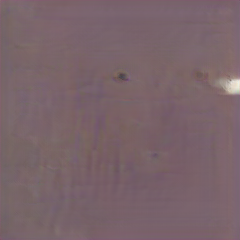

i: 50, loss: 0.820296, losses: 0.820296


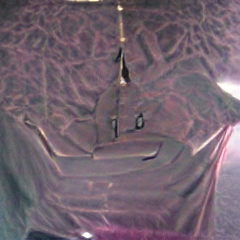

i: 100, loss: 0.727241, losses: 0.727241


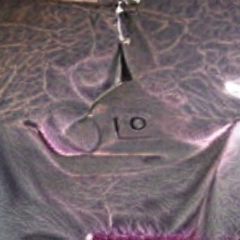

i: 150, loss: 0.650944, losses: 0.650944


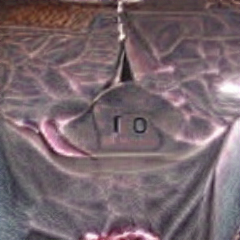

i: 200, loss: 0.651125, losses: 0.651125


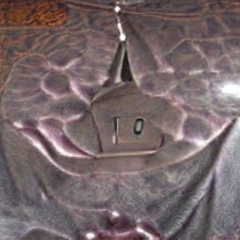

i: 250, loss: 0.64725, losses: 0.64725


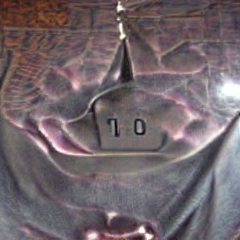

i: 300, loss: 0.64307, losses: 0.64307


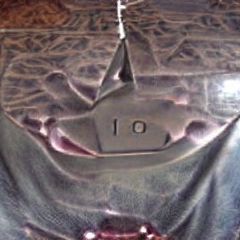

i: 350, loss: 0.637911, losses: 0.637911


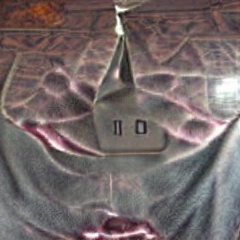

i: 400, loss: 0.64677, losses: 0.64677


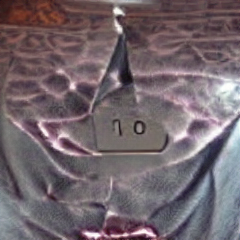

i: 450, loss: 0.611999, losses: 0.611999


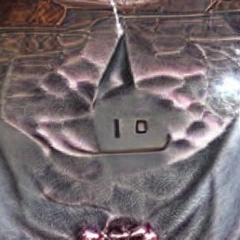

i: 500, loss: 0.61616, losses: 0.61616


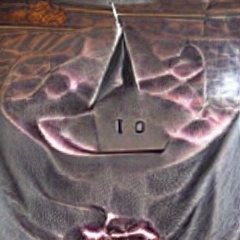

i: 550, loss: 0.581328, losses: 0.581328


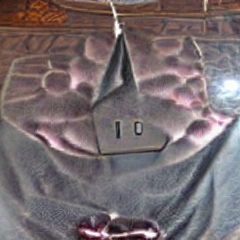

i: 600, loss: 0.611578, losses: 0.611578


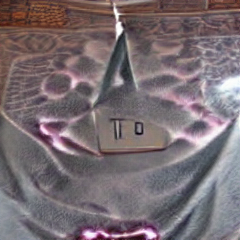

i: 650, loss: 0.603618, losses: 0.603618


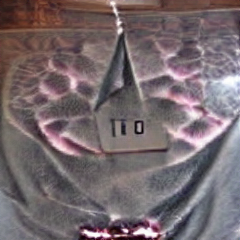

i: 700, loss: 0.61278, losses: 0.61278


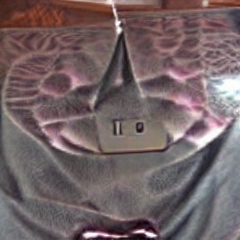

i: 750, loss: 0.601861, losses: 0.601861


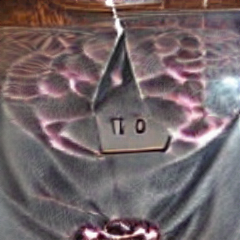

i: 800, loss: 0.615255, losses: 0.615255


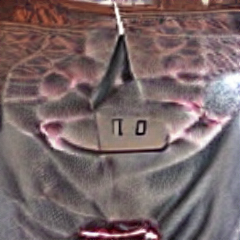

In [8]:
#@markdown generation could take upto 10 minutes
text = 'пустыня'#@param{type:'string'}
iter = 800 #@param {type:"slider", min:100, max:100000, step:100}
size_x = 250 #@param {type:"slider", min:100, max:2000, step:10}
size_y = 250 #@param {type:"slider", min:100, max:2000, step:10}
text2image_QHM(text = text, iter = iter, path = './', rand = 0, x=size_x, y=size_y)

#Developed by Sber creative Ai
- Alex Shonenkov
- Denis Dimitrov
- Alex Nikolich
- Ksenia Ivanova